<a href="https://colab.research.google.com/github/hepi1911/ML/blob/main/Project_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score

Dataset: https://www.kaggle.com/datasets/mansoordaku/ckdisease/data

In [2]:
import kagglehub as kgb

# Download latest version
path = kgb.dataset_download("mansoordaku/ckdisease")

print("Path to dataset files:", path)

100%|██████████| 9.51k/9.51k [00:00<00:00, 16.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mansoordaku/ckdisease/versions/1


# Data Exploration

In [3]:
df = pd.read_csv(f'{path}/kidney_disease.csv')
df

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,51,7200,5.9,no,no,no,good,no,no,notckd


In [5]:
column_names_mapping = {
    'pcv': 'Packed Cell Volume',
    'sc': 'Serum Creatinine',
    'hemo': 'Hemoglobin',
    'rc': 'Red Blood Cells Count',
    'sg': 'Specific Gravity',
    'al': 'Albumin',
    'dm': 'Diabetes Mellitus',
    'htn': 'Hypertension',
    'bu': 'Blood Urea',
    'bgr': 'Blood Glucose Random',
    'sod': 'Sodium',
    'age': 'Age',
    'bp': 'Blood Pressure',
    'pe': 'Pedal Edema',
    'pot': 'Potassium',
    'wc': 'White Blood Cells Count',
    'pc': 'Pus Cell',
    'su': 'Sugar',
    'rbc': 'Red Blood Cells',
    'appet': 'Appetite',
    'ane': 'Anemia',
    'pcc': 'Pus Cell Clumps',
    'cad': 'Coronary Artery Disease',
    'ba': 'Bacteria'
}

df = df.rename(columns=column_names_mapping)

EDA to be taken with great caution ( lots of values and information ) we'll have to reduce

## Missing values

                         Missing values  Percentage (%)
Red Blood Cells                     152           38.00
Red Blood Cells Count               130           32.50
White Blood Cells Count             105           26.25
Potassium                            88           22.00
Sodium                               87           21.75
Packed Cell Volume                   70           17.50
Pus Cell                             65           16.25
Hemoglobin                           52           13.00
Sugar                                49           12.25
Specific Gravity                     47           11.75
Albumin                              46           11.50
Blood Glucose Random                 44           11.00
Blood Urea                           19            4.75
Serum Creatinine                     17            4.25
Blood Pressure                       12            3.00
Age                                   9            2.25
Pus Cell Clumps                       4         

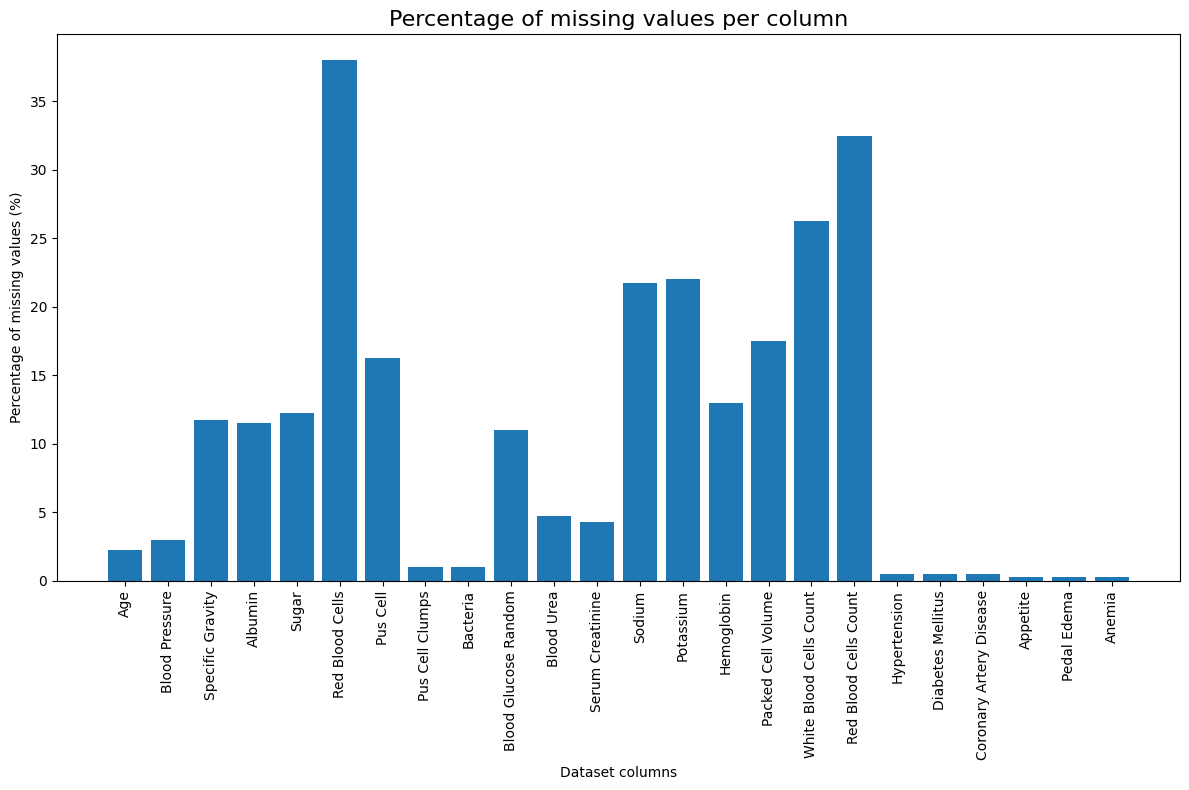

In [6]:
# 1. Analysis of missing values
df_clean = df.replace(['\t', '?', '', 'nan', 'NaN', 'na'], np.nan)

# Counting missing values
missing_values = df_clean.isnull().sum()
missing_percent = (df_clean.isnull().sum() / len(df_clean)) * 100
missing_df = pd.DataFrame({
    'Missing values': missing_values,
    'Percentage (%)': missing_percent.round(2)
})
print(missing_df[missing_df['Missing values'] > 0].sort_values('Percentage (%)', ascending=False))

# Displaying missing values
plt.figure(figsize=(12, 8))
plt.title('Percentage of missing values per column', fontsize=16)
plt.bar(missing_df[missing_df['Missing values'] > 0].index,
        missing_df[missing_df['Missing values'] > 0]['Percentage (%)'])
plt.xticks(rotation=90)
plt.ylabel('Percentage of missing values (%)')
plt.xlabel('Dataset columns')
plt.tight_layout()
plt.savefig('missing_values.png')

## Categorical values exploration

In [7]:
# 2. Analysis of categorical variables
#categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

all_columns = df_clean.columns

for col in all_columns:
    if not pd.isna(df_clean[col]).all():
        value_counts = df_clean[col].value_counts(dropna=False)
        print(f"\nDistribution of '{col}':")
        print(value_counts)

        # Display (TOP 10 only to avoid saturation)
        plt.figure(figsize=(15, 6))
        sns.countplot(y=df_clean[col].astype(str), order=value_counts.index[:10])
        plt.title(f'Distribution of categories for {col}', fontsize=14)
        plt.xlabel('Number of observations')
        plt.ylabel('Values (as string)')
        plt.tight_layout()
        plt.savefig(f'distribution_{col}.png')
        plt.close()
        plt.show()




Distribution of 'id':
id
383    1
382    1
381    1
380    1
379    1
      ..
4      1
3      1
2      1
1      1
0      1
Name: count, Length: 400, dtype: int64

Distribution of 'Age':
Age
60.0    19
65.0    17
48.0    12
55.0    12
50.0    12
        ..
90.0     1
2.0      1
78.0     1
22.0     1
79.0     1
Name: count, Length: 77, dtype: int64

Distribution of 'Blood Pressure':
Blood Pressure
80.0     116
70.0     112
60.0      71
90.0      53
100.0     25
NaN       12
50.0       5
110.0      3
140.0      1
180.0      1
120.0      1
Name: count, dtype: int64

Distribution of 'Specific Gravity':
Specific Gravity
1.020    106
1.010     84
1.025     81
1.015     75
NaN       47
1.005      7
Name: count, dtype: int64

Distribution of 'Albumin':
Albumin
0.0    199
NaN     46
1.0     44
3.0     43
2.0     43
4.0     24
5.0      1
Name: count, dtype: int64

Distribution of 'Sugar':
Sugar
0.0    290
NaN     49
2.0     18
3.0     14
4.0     13
1.0     13
5.0      3
Name: count, dtype: int6

<ipython-input-7-97ebdd4df04a>:18: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-7-97ebdd4df04a>:19: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f'distribution_{col}.png')



Distribution of 'Coronary Artery Disease':
Coronary Artery Disease
no      362
yes      34
\tno      2
NaN       2
Name: count, dtype: int64


<ipython-input-7-97ebdd4df04a>:18: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-7-97ebdd4df04a>:19: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f'distribution_{col}.png')



Distribution of 'Appetite':
Appetite
good    317
poor     82
NaN       1
Name: count, dtype: int64

Distribution of 'Pedal Edema':
Pedal Edema
no     323
yes     76
NaN      1
Name: count, dtype: int64

Distribution of 'Anemia':
Anemia
no     339
yes     60
NaN      1
Name: count, dtype: int64

Distribution of 'classification':
classification
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64


<ipython-input-7-97ebdd4df04a>:18: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-7-97ebdd4df04a>:19: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f'distribution_{col}.png')


## Numerical data exploration


Statistics for 'id':
count    400.000000
mean     199.500000
std      115.614301
min        0.000000
25%       99.750000
50%      199.500000
75%      299.250000
max      399.000000
Name: id, dtype: float64

Statistics for 'Age':
count    391.000000
mean      51.483376
std       17.169714
min        2.000000
25%       42.000000
50%       55.000000
75%       64.500000
max       90.000000
Name: Age, dtype: float64

Statistics for 'Blood Pressure':
count    388.000000
mean      76.469072
std       13.683637
min       50.000000
25%       70.000000
50%       80.000000
75%       80.000000
max      180.000000
Name: Blood Pressure, dtype: float64

Statistics for 'Specific Gravity':
count    353.000000
mean       1.017408
std        0.005717
min        1.005000
25%        1.010000
50%        1.020000
75%        1.020000
max        1.025000
Name: Specific Gravity, dtype: float64

Statistics for 'Albumin':
count    354.000000
mean       1.016949
std        1.352679
min        0.000000
25%        

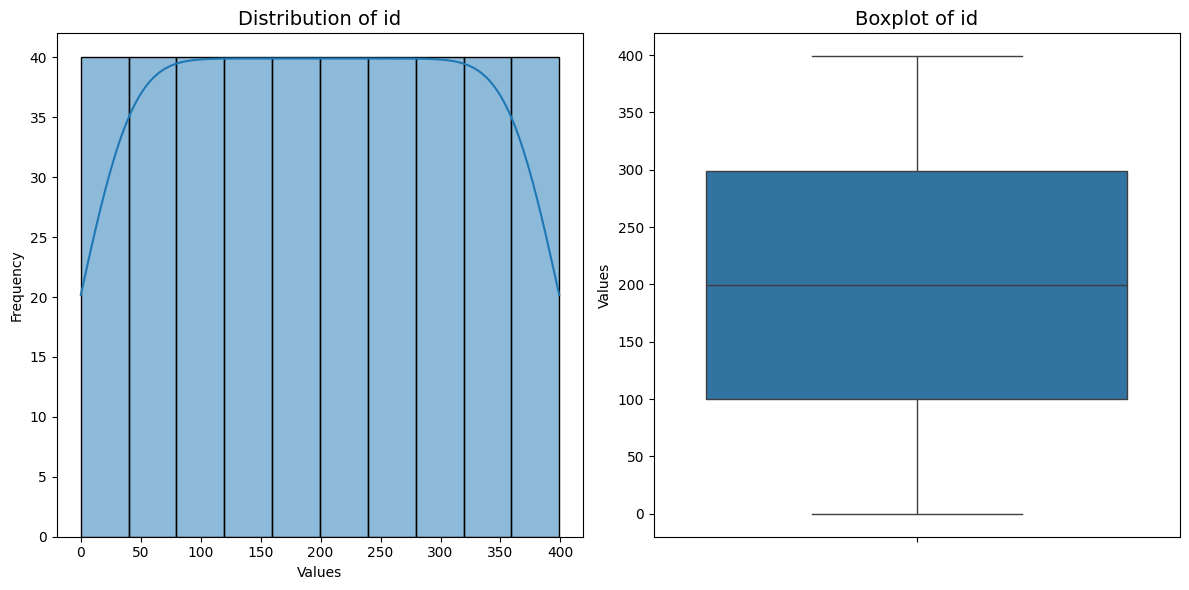

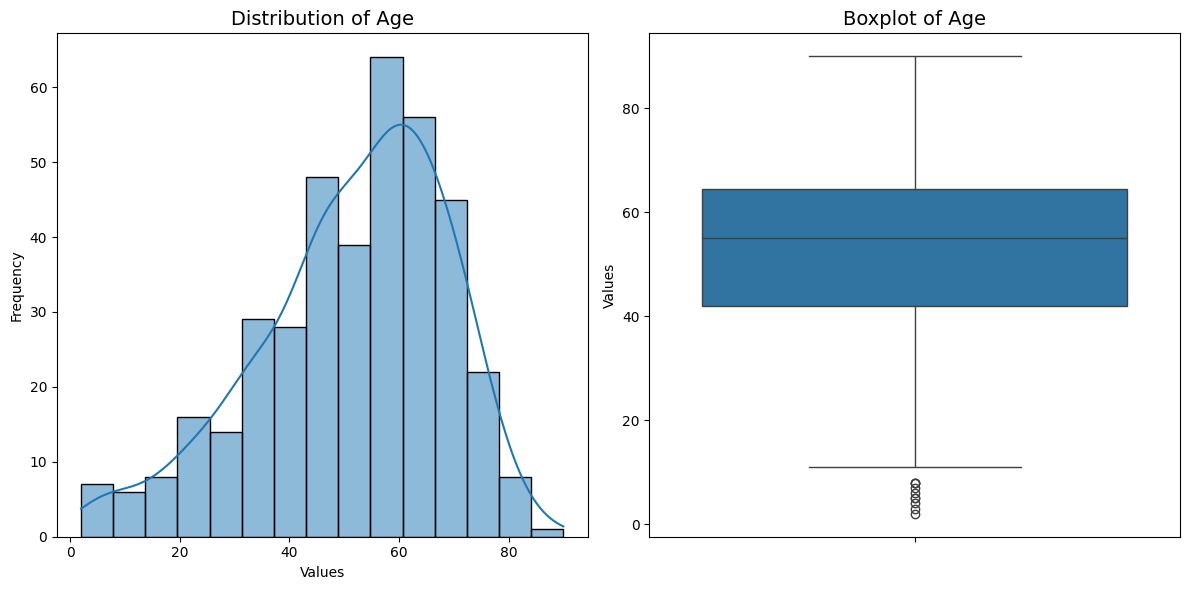

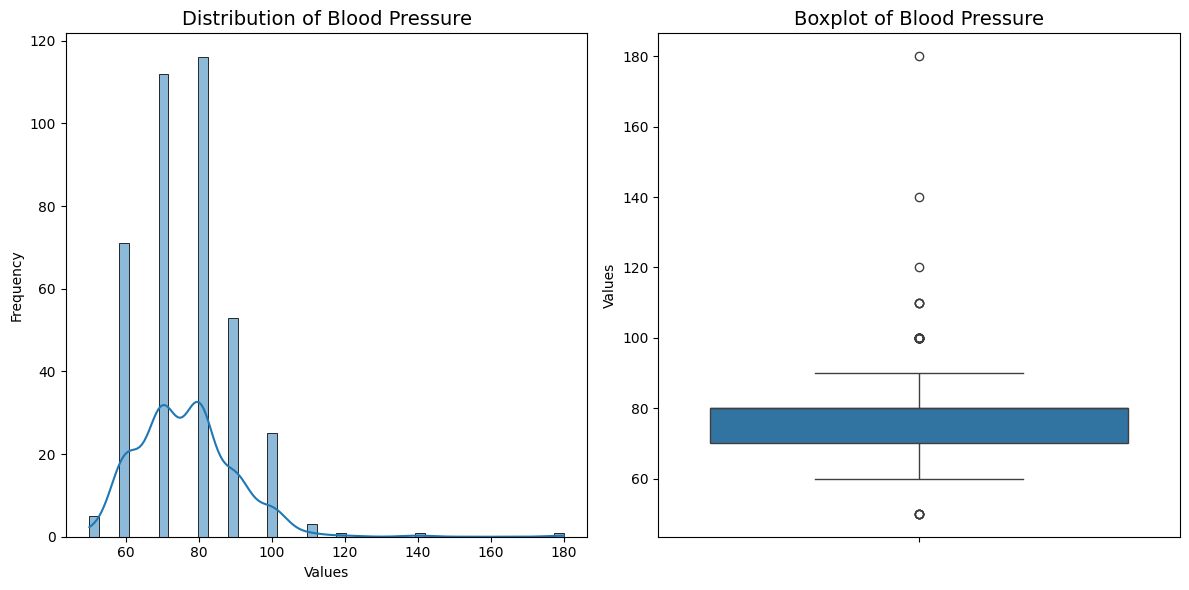

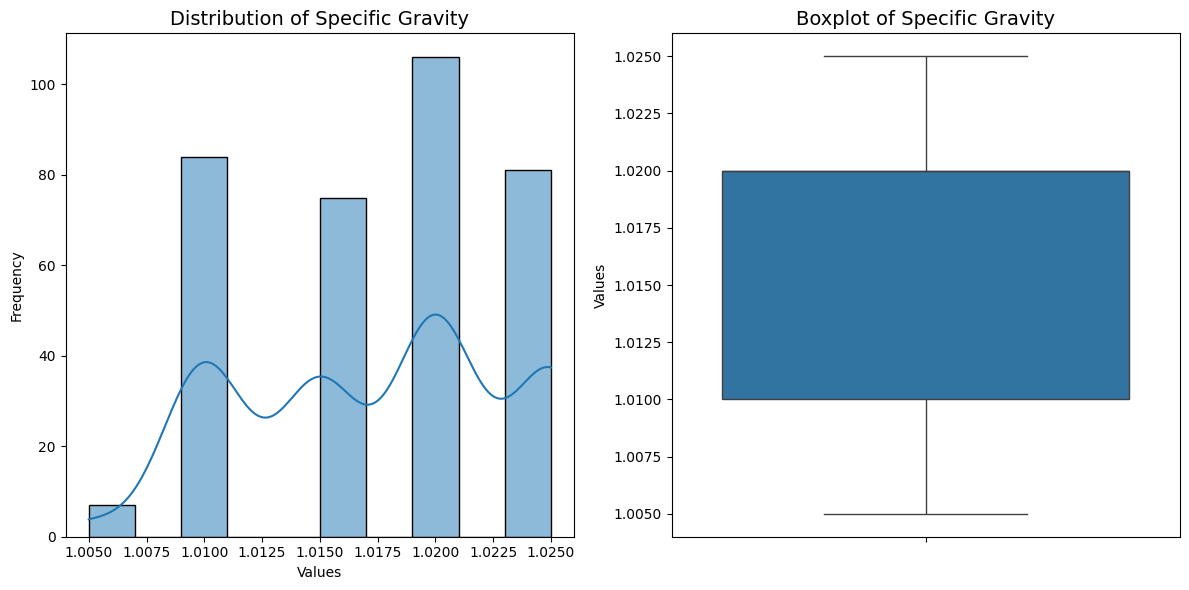

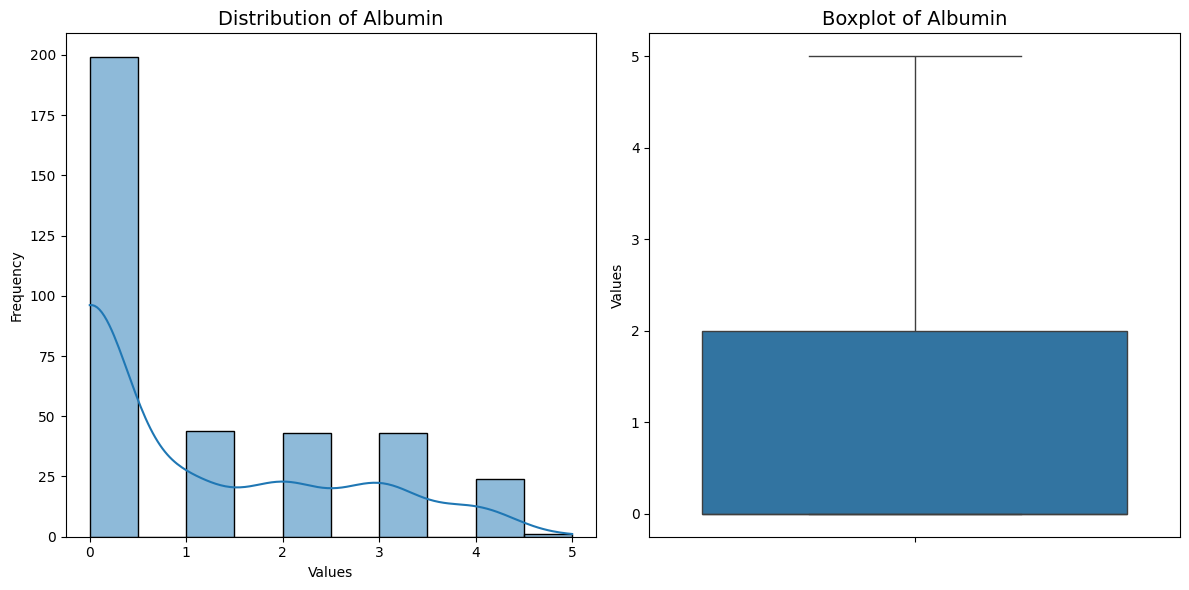

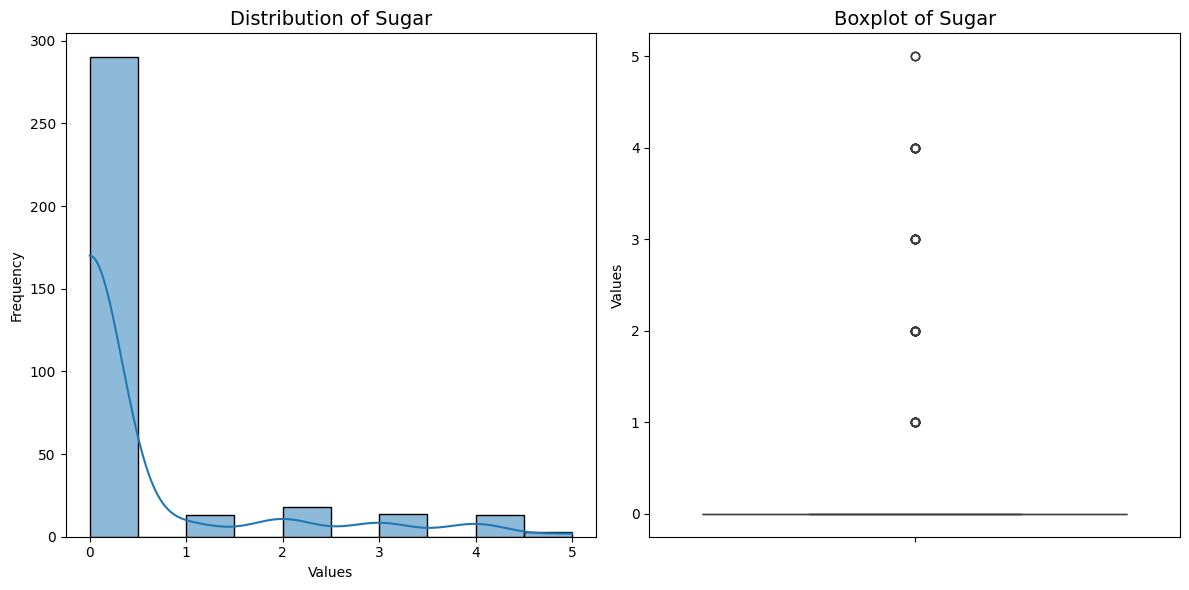

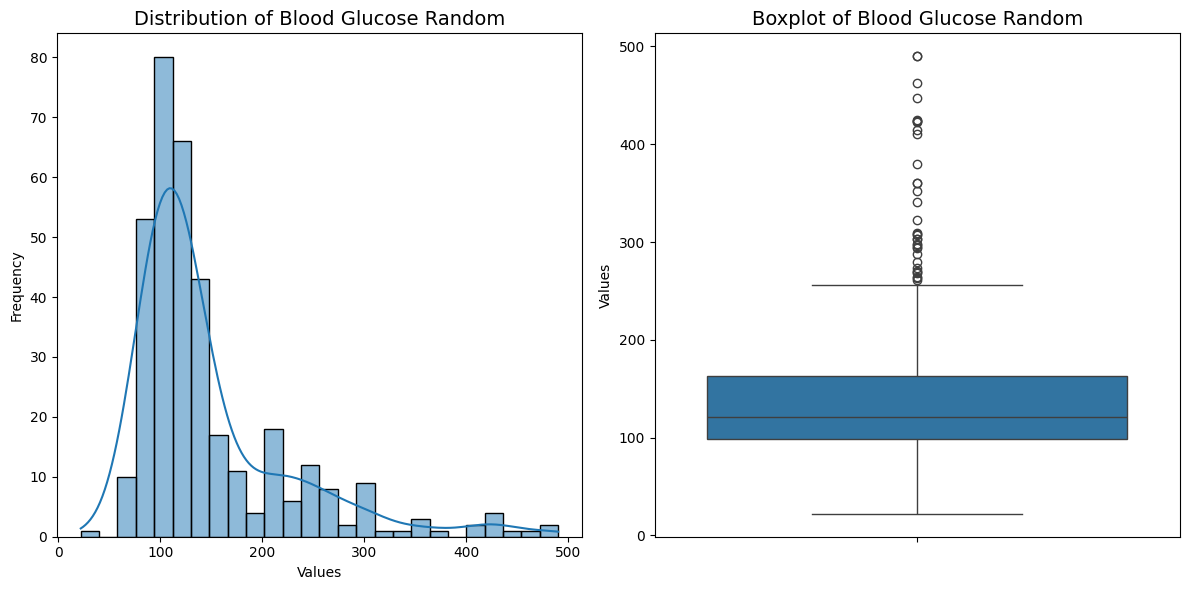

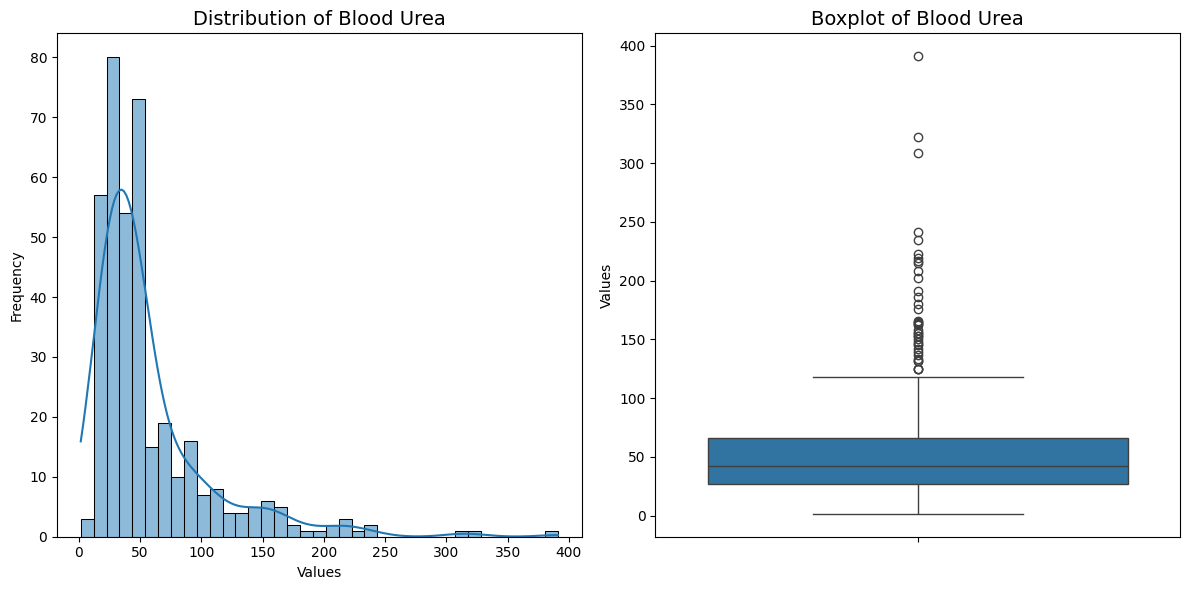

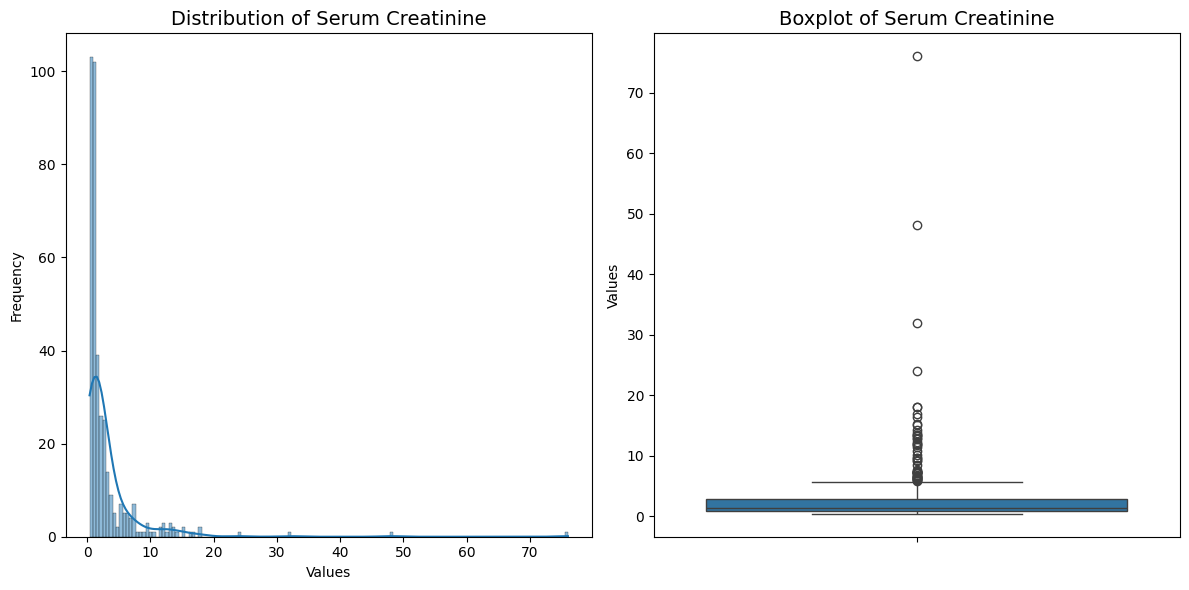

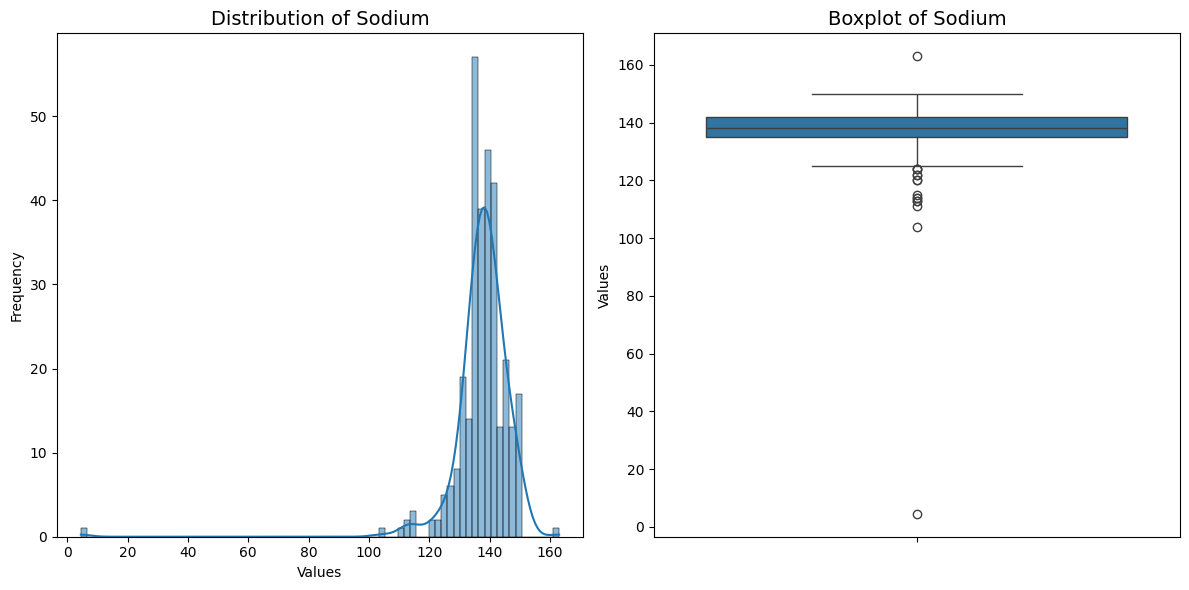

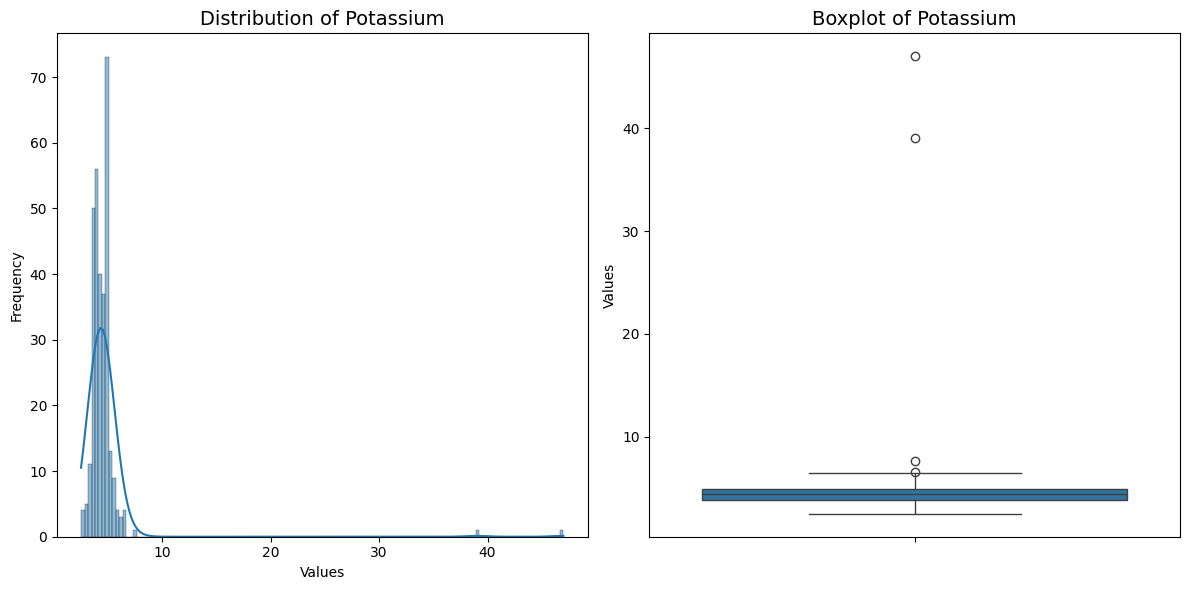

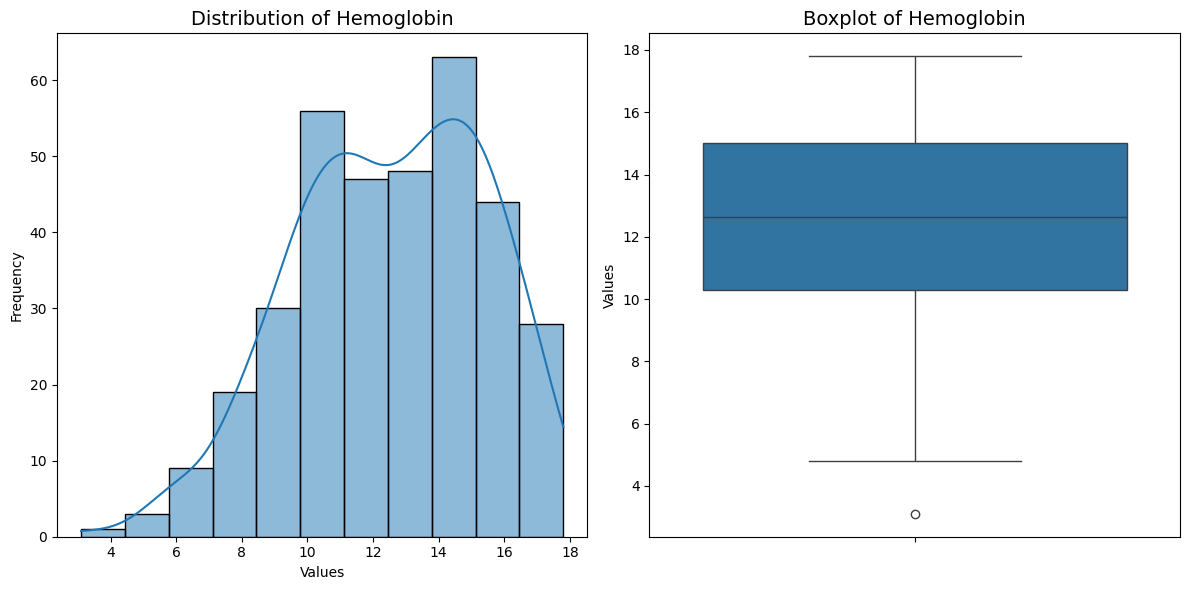

In [8]:
# 3. Analysis of numerical variables
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in numeric_cols:
    print(f"\nStatistics for '{col}':")
    print(df_clean[col].describe())

    # Histogram et boxplot
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_clean[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel('Values')
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_clean[col].dropna())
    plt.title(f'Boxplot of {col}', fontsize=14)
    plt.ylabel('Values')

    plt.tight_layout()
    plt.savefig(f'numeric_{col}.png')


## Correlation analysis

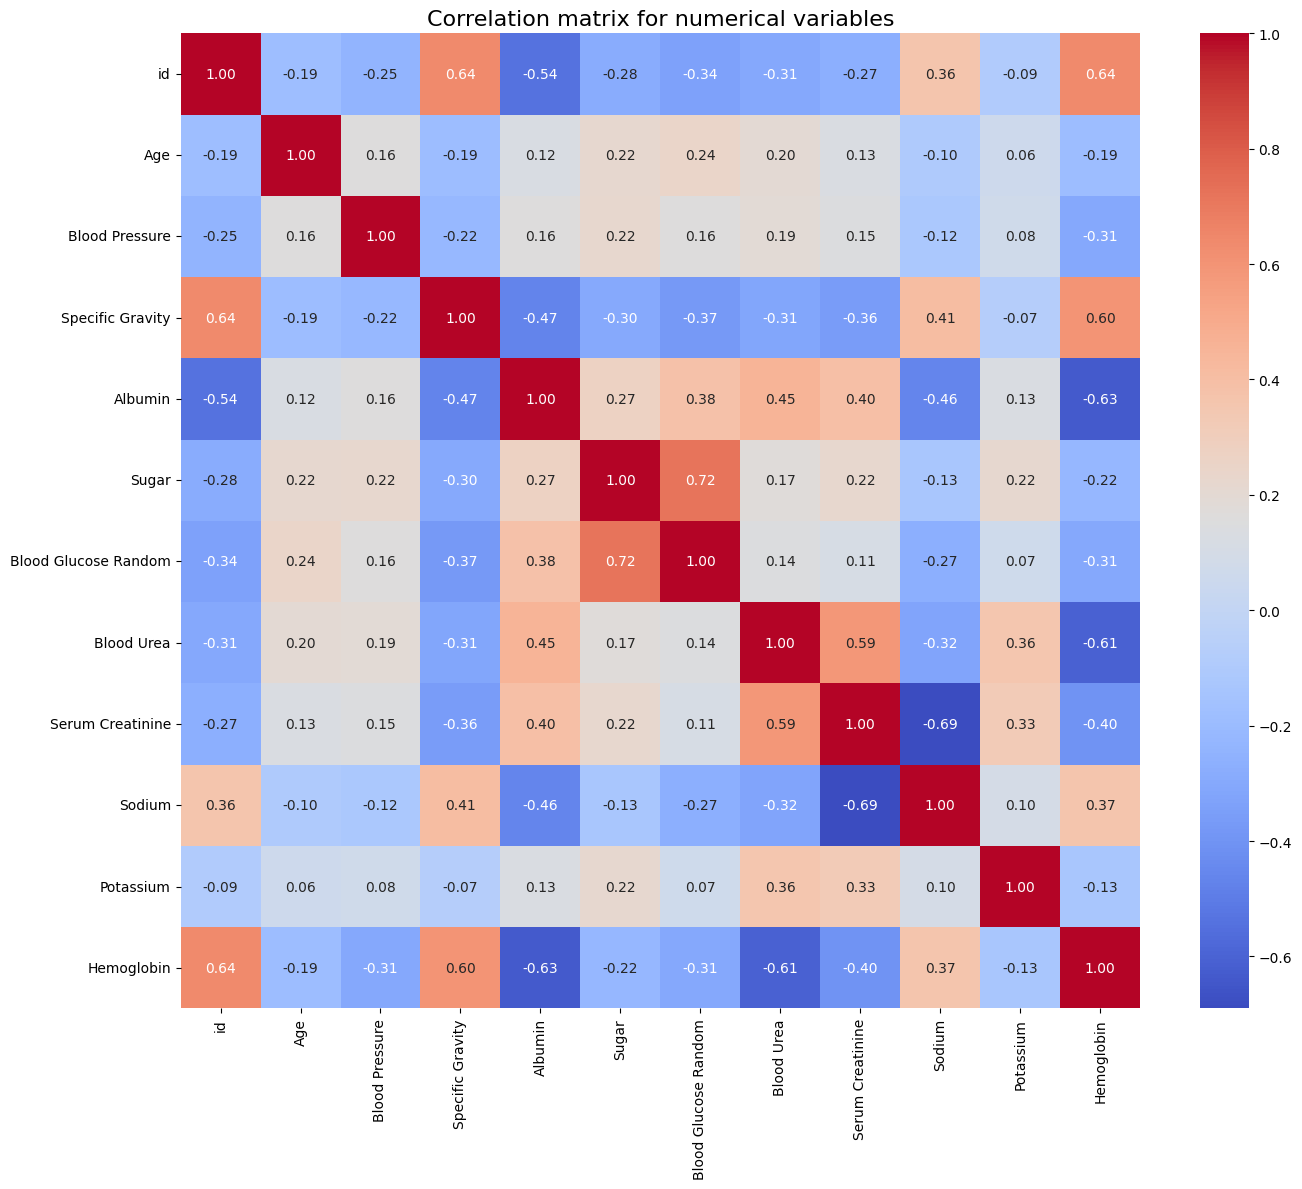

In [9]:
# 5. Analysis of correlations
correlation_matrix = df_clean.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation matrix for numerical variables', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png')


# Pre-Processing

1. Converting categorical data into binary
First, we identify the columns containing categorical data and convert them into binary values (0 and 1):

We have created a binary_mappings dictionary containing the conversion rules for each known categorical column in the kidney-disease dataset:

For columns such as 'rbc', 'pc': "normal" becomes 1, "abnormal" becomes 0
For 'pcc', 'ba': "present" becomes 1, "notpresent" becomes 0
For 'htn', 'dm', 'cad', 'pe', 'ane': "yes" becomes 1, "no" becomes 0
For 'appet': "good" becomes 1, "poor" becomes 0
For 'class' (the target variable): "ckd" (chronic kidney disease) becomes 1, "notckd" becomes 0


The values are first cleaned up (spaces removed, conversion to lower case) to ensure consistency
The map() method of pandas is then used to perform the conversion according to the defined dictionary

This conversion transforms textual data into numerical values, which is essential for most machine learning algorithms.
2. Imputation of missing values
After converting all the columns into numerical format, we apply a cascade imputation strategy for missing values:

Test with the median:

For each column, we calculate the median of the existing values
The median is preferred to the mean because it is less sensitive to extreme values
If the median can be calculated (enough values available), we use it to replace all the missing values in that column.


Fallback to the mean:

If the median is itself NaN (can happen if too few values are available), we try with the mean
The mean is calculated and used to replace missing values


Last resort with default value:

If neither the median nor the mean can be calculated (for example, if almost all the values are missing), we use 0 as the default value.


Special case of completely empty columns:

For columns where all values are missing, we replace directly with 0



This approach is progressive and adaptive, allowing us to deal efficiently with different types of column and different levels of missing data.
Advantages of this method

It is robust to problematic columns (such as those mentioned in the error: 'rbc', 'pc', 'pcc', 'ba', etc.)
It preserves the general distribution of the data by using the median as a priority
It guarantees that no missing values remain in the final dataset, which is essential for most machine learning algorithms
The prior binary conversion simplifies the future interpretation of the results.

In [10]:
# Replace problematic values with NaN
df = df.replace(['\t', '?', '', 'nan', 'NaN', 'na'], np.nan)

## Conversion of categorical data into numerical

In [11]:
# First step : Converting categorial columns into binary
# List of common categorical columns in the kidney-disease dataset
binary_mappings = {
    'rbc': {'normal': 1, 'abnormal': 0},
    'pc': {'normal': 1, 'abnormal': 0},
    'pcc': {'present': 1, 'notpresent': 0},
    'ba': {'present': 1, 'notpresent': 0},
    'htn': {'yes': 1, 'no': 0},
    'dm': {'yes': 1, 'no': 0},
    'cad': {'yes': 1, 'no': 0},
    'appet': {'good': 1, 'poor': 0},
    'pe': {'yes': 1, 'no': 0},
    'ane': {'yes': 1, 'no': 0}
}

# Check whether “class” or “classification” exists in the dataframe
if 'class' in df.columns:
    binary_mappings['class'] = {'ckd': 1, 'notckd': 0}
elif 'classification' in df.columns:
    binary_mappings['classification'] = {'ckd': 1, 'notckd': 0}

# Clean up and convert text columns + binary mapping
for col in df.select_dtypes(include=['object']).columns:
    if not df[col].isna().all():
        df[col] = df[col].str.strip().str.lower()

        # If the column is one of the columns to be mapped
        if col in binary_mappings:
            df[col] = df[col].map(binary_mappings[col])
            print(f"Binary conversion for {col} - Nan values: {df[col].isna().sum()}")
        else:
            # Try converting to numeric if it's not a binary column
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                print(f"Column {col} converted into binary")
            except Exception as e:
                print(f"Binary conversion failure for {col}: {e}")


Column Red Blood Cells converted into binary
Column Pus Cell converted into binary
Column Pus Cell Clumps converted into binary
Column Bacteria converted into binary
Column Packed Cell Volume converted into binary
Column White Blood Cells Count converted into binary
Column Red Blood Cells Count converted into binary
Column Hypertension converted into binary
Column Diabetes Mellitus converted into binary
Column Coronary Artery Disease converted into binary
Column Appetite converted into binary
Column Pedal Edema converted into binary
Column Anemia converted into binary
Binary conversion for classification - Nan values: 0


## Data imputation

In [12]:
for col in df.columns:
    if not df[col].dropna().empty:
        median_value = df[col].median()
        if pd.notna(median_value):
            df[col] = df[col].fillna(median_value)
            print(f"Column {col} - imputation with median: {median_value}")
        else:
            mean_value = df[col].mean()
            if pd.notna(mean_value):
                df[col] = df[col].fillna(mean_value)
                print(f"Column {col} - imputation with mean: {mean_value}")
            else:
                df[col] = df[col].fillna(0)
                print(f"Column {col} - imputation with 0 (fallback)")
    else:
        df[col] = df[col].fillna(0)
        print(f"Column {col} totally empty - replaced with 0")


Column id - imputation with median: 199.5
Column Age - imputation with median: 55.0
Column Blood Pressure - imputation with median: 80.0
Column Specific Gravity - imputation with median: 1.02
Column Albumin - imputation with median: 0.0
Column Sugar - imputation with median: 0.0
Column Red Blood Cells totally empty - replaced with 0
Column Pus Cell totally empty - replaced with 0
Column Pus Cell Clumps totally empty - replaced with 0
Column Bacteria totally empty - replaced with 0
Column Blood Glucose Random - imputation with median: 121.0
Column Blood Urea - imputation with median: 42.0
Column Serum Creatinine - imputation with median: 1.3
Column Sodium - imputation with median: 138.0
Column Potassium - imputation with median: 4.4
Column Hemoglobin - imputation with median: 12.649999999999999
Column Packed Cell Volume - imputation with median: 40.0
Column White Blood Cells Count - imputation with median: 8000.0
Column Red Blood Cells Count - imputation with median: 4.8
Column Hyperten

## Verifications

In [13]:


# Check the result after cleaning
print("\nOverview of data after cleaning:")
print(df.head())
print("\nInformation after cleaning:")
print(df.info())
print("\nChecking remaining missing values:")
print(df.isnull().sum())

# Final statistical analysis
print("\nDescriptive statistics after conversion and imputation:")
print(df.describe())

# Save the cleaned dataset
df.to_csv('kidney_disease_cleaned_binary.csv', index=False)
print("\nCleaned file saved as 'kidney_disease_cleaned_binary.csv'")

# Option: display the distribution of values to check
print("\nDistribution of values for some main columns:")
for col in df.columns[:5]:  # Limited to the first 5 columns
    print(f"\nDistribution of {col}:")
    print(df[col].value_counts())

# Specific verification of the target variable (class or classification)
if 'class' in df.columns:
    print("\nDistribution of the 'class' target variable:")
    print(df['class'].value_counts())
elif 'classification' in df.columns:
    print("\nDistribution of the 'classification' target variable:")
    print(df['classification'].value_counts())


Overview of data after cleaning:
   id   Age  Blood Pressure  Specific Gravity  Albumin  Sugar  \
0   0  48.0            80.0             1.020      1.0    0.0   
1   1   7.0            50.0             1.020      4.0    0.0   
2   2  62.0            80.0             1.010      2.0    3.0   
3   3  48.0            70.0             1.005      4.0    0.0   
4   4  51.0            80.0             1.010      2.0    0.0   

   Red Blood Cells  Pus Cell  Pus Cell Clumps  Bacteria  ...  \
0              0.0       0.0              0.0       0.0  ...   
1              0.0       0.0              0.0       0.0  ...   
2              0.0       0.0              0.0       0.0  ...   
3              0.0       0.0              0.0       0.0  ...   
4              0.0       0.0              0.0       0.0  ...   

   Packed Cell Volume  White Blood Cells Count  Red Blood Cells Count  \
0                44.0                   7800.0                    5.2   
1                38.0                   6000

Deleting the id column. This was causing us problems on KNN, so we've removed it.

In [14]:
# Deleting the 'id' column
df = df.drop('id', axis=1)
print("'id' column deleted. Dataset dimensions:", df.shape)
df

'id' column deleted. Dataset dimensions: (400, 25)


,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell Clumps,Bacteria,Blood Glucose Random,...,Packed Cell Volume,White Blood Cells Count,Red Blood Cells Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,classification
0,48.0,80.0,1.020,1.0,0.0,0.0,0.0,0.0,0.0,121.0,...,44.0,7800.0,5.2,0.0,0.0,0.0,0.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,0.0,0.0,0.0,0.0,121.0,...,38.0,6000.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,...,31.0,7500.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,1
3,48.0,70.0,1.005,4.0,0.0,0.0,0.0,0.0,0.0,117.0,...,32.0,6700.0,3.9,0.0,0.0,0.0,0.0,0.0,0.0,1
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,35.0,7300.0,4.6,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,140.0,...,47.0,6700.0,4.9,0.0,0.0,0.0,0.0,0.0,0.0,0
396,42.0,70.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,75.0,...,54.0,7800.0,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0
397,12.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,100.0,...,49.0,6600.0,5.4,0.0,0.0,0.0,0.0,0.0,0.0,0
398,17.0,60.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,114.0,...,51.0,7200.0,5.9,0.0,0.0,0.0,0.0,0.0,0.0,0


This Python script allows you to explore a dataset in depth for a machine learning project. We developed this code to quickly analyse the structure and characteristics of a dataset before starting pre-processing and modelling.
Features
1. General information
The code starts by displaying the dimensions of the dataset (number of rows and columns) and a preview of the first few rows. This gives us an overview of the data we'll be working with.
2. Analysis of columns and data types
We then display the complete list of columns with their respective data types. This step is crucial for identifying which variables are numerical, categorical, etc.
3. Detailed analysis of unique values
For each column in the dataset:

We display the number of unique values
If the column contains few unique values (≤ 10), we display them for quick inspection
We display the distribution of values to understand their distribution
We automatically flag binary columns that could be used as target variables

4. Identification of potential target variables
The code intelligently searches for columns that could serve as target variables for a classification problem:

Columns with a limited number of unique values (2-5)
Discrete numeric variables
Display their distribution to assess class balance

5. Specific verification of the 'classification' variable
If a column named 'classification' exists (common name for a target variable):

We specifically analyse this column
We check that it contains more than one value (if not, it cannot be used for classification)
We display its detailed distribution

6. Search for columns linked to a class
The code also searches for columns containing 'class' in their name, which are often target variables.
7. Conclusion and recommendations
Finally, we provide a conclusion with:

A recommendation of the best target variable identified
A preference for variables with a balanced class distribution
A warning if no suitable target variable is identified

In [15]:
# 1. Analysis of unique values for each column
print("\n--- Unique values per column ---")
for col in df.columns:
    unique_vals = df[col].unique()
    n_unique = len(unique_vals)
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {n_unique}")

    # If few unique values, displaying them
    if n_unique <= 10:
        print("Unique values:", unique_vals)

    # Distribution of the values
    val_counts = df[col].value_counts()
    print("Distribution:")
    print(val_counts)

    # Check whether the column could be a binary target variable
    if n_unique == 2:
        print("This column could be a binary target variable")



--- Unique values per column ---

Column: Age
Number of unique values: 76
Distribution:
Age
55.0    21
60.0    19
65.0    17
48.0    12
50.0    12
        ..
90.0     1
2.0      1
78.0     1
22.0     1
79.0     1
Name: count, Length: 76, dtype: int64

Column: Blood Pressure
Number of unique values: 10
Unique values: [ 80.  50.  70.  90. 100.  60. 110. 140. 180. 120.]
Distribution:
Blood Pressure
80.0     128
70.0     112
60.0      71
90.0      53
100.0     25
50.0       5
110.0      3
140.0      1
180.0      1
120.0      1
Name: count, dtype: int64

Column: Specific Gravity
Number of unique values: 5
Unique values: [1.02  1.01  1.005 1.015 1.025]
Distribution:
Specific Gravity
1.020    153
1.010     84
1.025     81
1.015     75
1.005      7
Name: count, dtype: int64

Column: Albumin
Number of unique values: 6
Unique values: [1. 4. 2. 3. 0. 5.]
Distribution:
Albumin
0.0    245
1.0     44
3.0     43
2.0     43
4.0     24
5.0      1
Name: count, dtype: int64

Column: Sugar
Number of uniq

In [16]:
# 2. Search for columns that could be target variables
potential_targets = []
for col in df.columns:
    # Check that the column has few unique values (ideal for classification)
    n_unique = df[col].nunique()
    if 1 < n_unique <= 5:  # Between 2 and 5 classes
        # Check whether the values are numerical and discrete
        if df[col].dtype in ['int64', 'float64']:
            # Check whether the values are discrete (no continuous valuesMissingData.com)
            if len(df[col].value_counts()) <= 5:
                potential_targets.append(col)

print("\n--- Potential columns for the target variable ---")
for col in potential_targets:
    print(f"Column: {col}")
    print("Unique values:", df[col].unique())
    print("Distribution:")
    print(df[col].value_counts())
    print()


--- Potential columns for the target variable ---
Column: Specific Gravity
Unique values: [1.02  1.01  1.005 1.015 1.025]
Distribution:
Specific Gravity
1.020    153
1.010     84
1.025     81
1.015     75
1.005      7
Name: count, dtype: int64

Column: classification
Unique values: [1 0]
Distribution:
classification
1    250
0    150
Name: count, dtype: int64



In [17]:
# 3. Specific verification of the “classification” variable
if 'classification' in df.columns:
    print("\n--- Specific analysis of the “classification” variable ---")
    print("Unique values:", df['classification'].unique())
    print("Distribution:")
    print(df['classification'].value_counts())

    # If “classification” contains only one value, this is a problem
    if df['classification'].nunique() == 1:
        print("ALERT: The “classification” column contains only one value!")
        print("It cannot be used as a target variable for a classification problem.")


--- Specific analysis of the “classification” variable ---
Unique values: [1 0]
Distribution:
classification
1    250
0    150
Name: count, dtype: int64


In [18]:
# 4. Check for the presence of a “class” or similar column
class_cols = [col for col in df.columns if 'class' in col.lower()]
if class_cols:
    print("\n--- Columns containing “class” in their name ---")
    for col in class_cols:
        print(f"Column: {col}")
        print("Unique values:", df[col].unique())
        print("Distribution:")
        print(df[col].value_counts())
        print()

# 8. Conclusion and recommendations
print("\n--- Conclusion and recommendations ---")
if potential_targets:
    best_target = potential_targets[0]  # By default, let's take the first
    for col in potential_targets:
        # Prefer columns with more balanced distribution
        if df[col].nunique() > 1 and df[col].value_counts().min() > df[best_target].value_counts().min():
            best_target = col

    print(f"The best target variable seems to be '{best_target}'")
    print("Distribution:")
    print(df[best_target].value_counts())
else:
    print("No appropriate column for a target variable has been identified.")
    print("Check the data pre-processing process.")


--- Columns containing “class” in their name ---
Column: classification
Unique values: [1 0]
Distribution:
classification
1    250
0    150
Name: count, dtype: int64


--- Conclusion and recommendations ---
The best target variable seems to be 'classification'
Distribution:
classification
1    250
0    150
Name: count, dtype: int64


In [19]:
X = df.drop('classification', axis=1)  # Replace 'class' with 'classification'
y = df['classification']  # Replace 'class' with 'classification'

# Create and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

importances = rf_model.feature_importances_
# Use X.columns instead of X_train.columns
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print("\n--- Importance of variables ---")
print(feature_importance)


--- Importance of variables ---
Hemoglobin                 0.255403
Packed Cell Volume         0.171087
Serum Creatinine           0.127394
Specific Gravity           0.105804
Albumin                    0.070379
Red Blood Cells Count      0.070299
Blood Urea                 0.042916
Sodium                     0.042251
Blood Glucose Random       0.041057
Age                        0.016694
Blood Pressure             0.015287
Sugar                      0.014854
White Blood Cells Count    0.014153
Potassium                  0.012422
Red Blood Cells            0.000000
Pus Cell                   0.000000
Pus Cell Clumps            0.000000
Bacteria                   0.000000
Hypertension               0.000000
Diabetes Mellitus          0.000000
Coronary Artery Disease    0.000000
Appetite                   0.000000
Pedal Edema                0.000000
Anemia                     0.000000
dtype: float64


In [20]:

importances = rf_model.feature_importances_
# Use X.columns instead of X_train.columns
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print("\n--- Importance of variables ---")
print(feature_importance)

# Calculate importances in percentage
importances_percent = importances * 100

# Create a DataFrame to display the results
feature_importance_df = pd.DataFrame({
    'Index': range(len(X.columns)),
    'Feature': X.columns,
    'Importance (%)': importances_percent
}).sort_values('Importance (%)', ascending=False)



--- Importance of variables ---
Hemoglobin                 0.255403
Packed Cell Volume         0.171087
Serum Creatinine           0.127394
Specific Gravity           0.105804
Albumin                    0.070379
Red Blood Cells Count      0.070299
Blood Urea                 0.042916
Sodium                     0.042251
Blood Glucose Random       0.041057
Age                        0.016694
Blood Pressure             0.015287
Sugar                      0.014854
White Blood Cells Count    0.014153
Potassium                  0.012422
Red Blood Cells            0.000000
Pus Cell                   0.000000
Pus Cell Clumps            0.000000
Bacteria                   0.000000
Hypertension               0.000000
Diabetes Mellitus          0.000000
Coronary Artery Disease    0.000000
Appetite                   0.000000
Pedal Edema                0.000000
Anemia                     0.000000
dtype: float64


# Model Training

Classification entre els echantillons d'entrainenemnt et ceux de test

In [ ]:
# 1. Vérification de la variable cible
print("Distribution de la variable cible 'classification':")
print(df['classification'].value_counts())
print(f"Pourcentage: {df['classification'].value_counts(normalize=True) * 100}")

Distribution de la variable cible 'classification':
classification
1    250
0    150
Name: count, dtype: int64
Pourcentage: classification
1    62.5
0    37.5
Name: proportion, dtype: float64


In [ ]:
# 2. Séparation des features et de la variable cible
X = df.drop('classification', axis=1)
y = df['classification']

In [ ]:
# 3. Division en ensembles d'entraînement et de test (70% / 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# 4. Sauvegarde des ensembles d'entraînement et de test
X_train.to_csv('X_train.csv', index=False)
pd.Series(y_train).to_csv('y_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
pd.Series(y_test).to_csv('y_test.csv', index=False)

In [ ]:
print("\nDivision des données terminée.")
print(f"Ensemble d'entraînement : {X_train.shape[0]} échantillons ({X_train.shape[1]} caractéristiques)")
print(f"Ensemble de test : {X_test.shape[0]} échantillons ({X_test.shape[1]} caractéristiques)")
print("\nDistribution dans l'ensemble d'entraînement:")
print(y_train.value_counts())
print(f"Pourcentage: {y_train.value_counts(normalize=True) * 100}")
print("\nDistribution dans l'ensemble de test:")
print(y_test.value_counts())
print(f"Pourcentage: {y_test.value_counts(normalize=True) * 100}")


Division des données terminée.
Ensemble d'entraînement : 280 échantillons (24 caractéristiques)
Ensemble de test : 120 échantillons (24 caractéristiques)

Distribution dans l'ensemble d'entraînement:
classification
1    175
0    105
Name: count, dtype: int64
Pourcentage: classification
1    62.5
0    37.5
Name: proportion, dtype: float64

Distribution dans l'ensemble de test:
classification
1    75
0    45
Name: count, dtype: int64
Pourcentage: classification
1    62.5
0    37.5
Name: proportion, dtype: float64


Dans le cadre de notre projet de prédiction des maladies rénales chroniques (CKD), nous avons sélectionné trois algorithmes de classification ayant des approches fondamentalement différentes. Cette diversité nous permet d'explorer différentes façons d'aborder le problème et de comparer leurs performances respectives.
Justification des modèles sélectionnés
1. Régression Logistique
Pourquoi ce modèle ?

Interprétabilité : La régression logistique fournit des coefficients facilement interprétables, permettant de comprendre l'influence de chaque facteur médical sur le risque de maladie rénale.
Efficacité avec des frontières linéaires : Bien que simple, ce modèle est souvent très efficace lorsque la relation entre les variables et la classe cible peut être approximée linéairement.
Robustesse : Moins susceptible au sur-apprentissage par rapport aux modèles plus complexes, surtout avec des datasets de taille modérée.
Rapidité : Exécution rapide tant pour l'entraînement que pour les prédictions, ce qui est crucial dans un contexte médical où les décisions doivent parfois être prises rapidement.
Probabilités calibrées : Fournit des probabilités bien calibrées, ce qui est essentiel en médecine où l'incertitude de la prédiction doit être quantifiée.

2. Random Forest
Pourquoi ce modèle ?

Capture de relations complexes : Capable de modéliser des interactions non-linéaires complexes entre les variables médicales, qui sont fréquentes dans les données physiologiques.
Robustesse aux valeurs aberrantes : Les données médicales contiennent souvent des cas atypiques ou extrêmes que le Random Forest gère bien.
Importance des variables : Fournit une mesure de l'importance des caractéristiques, permettant d'identifier les facteurs médicaux les plus critiques pour le diagnostic.
Réduction du risque de sur-apprentissage : Grâce à l'agrégation de multiples arbres entraînés sur des sous-ensembles différents des données.
Performance élevée : Généralement parmi les algorithmes les plus performants pour les problèmes de classification complexes.

3. K-Nearest Neighbors (KNN)
Pourquoi ce modèle ?

Approche non-paramétrique : Ne fait aucune hypothèse sur la distribution sous-jacente des données, ce qui est avantageux pour les données médicales où les relations peuvent être difficiles à modéliser explicitement.
Intuitivité : Le concept de "similarité" avec d'autres patients est intuitif et reflète la démarche médicale de comparaison avec des cas connus.
Adaptabilité locale : S'adapte aux structures locales des données, permettant de capturer des sous-groupes spécifiques de patients présentant des caractéristiques similaires.
Pas de phase d'entraînement : Particulièrement utile lorsque de nouvelles données sont régulièrement ajoutées, car le modèle s'adapte naturellement.
Efficacité prouvée : Bien que simple, KNN peut être très efficace pour des problèmes médicaux où la proximité entre les patients dans l'espace des caractéristiques est significative.


In [ ]:
X = df.drop('classification', axis=1)
y = df['classification']

In [ ]:
# Split en 70% train / 30% test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (280, 24), Test: (120, 24)


In [ ]:
# === 2. NORMALISATION ===

scaler = StandardScaler()
numeric_features = X_train.select_dtypes(include=['number']).columns

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

In [ ]:

# === 3. RANDOM FOREST (SUR TOUTES LES COLONNES) ===

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Accuracy & rapport de classification
print("\nRandom Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRapport de classification - Random Forest:\n", classification_report(y_test, y_pred_rf))



Random Forest - Accuracy: 0.9916666666666667

Rapport de classification - Random Forest:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.99      1.00      0.99        75

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



In [ ]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
y_prob_lr = model_lr.predict_proba(X_test)[:, 1]

print("\nRégression Logistique - Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nRapport de classification - Régression Logistique:\n", classification_report(y_test, y_pred_lr))


Régression Logistique - Accuracy: 0.9333333333333333

Rapport de classification - Régression Logistique:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        45
           1       0.95      0.95      0.95        75

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)
y_prob_knn = model_knn.predict_proba(X_test)[:, 1]

print("\nKNN - Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nRapport de classification - KNN:\n", classification_report(y_test, y_pred_knn))



KNN - Accuracy: 0.7416666666666667

Rapport de classification - KNN:
               precision    recall  f1-score   support

           0       0.63      0.76      0.69        45
           1       0.83      0.73      0.78        75

    accuracy                           0.74       120
   macro avg       0.73      0.74      0.73       120
weighted avg       0.76      0.74      0.75       120



In [ ]:
# === 4. COURBE ROC ===

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)


## Cross Validation

In [ ]:
model = RandomForestClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kfold, scoring='f1')
print("Cross-validation scores:", scores)
print("Average accuracy:", scores.mean())

Cross-validation scores: [0.99029126 0.98989899 1.         1.         0.94623656]
Average accuracy: 0.9852853622349395


# Evaluation

In [ ]:
# Calculer les métriques ROC pour les visualisations
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Évaluation des modèles
print("Régression Logistique - Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print("KNN - Accuracy:", accuracy_score(y_test, y_pred_knn))

# Afficher les rapports de classification
print("\nRapport de classification - Régression Logistique:\n", classification_report(y_test, y_pred_lr))
print("\nRapport de classification - Random Forest:\n", classification_report(y_test, y_pred_rf))
print("\nRapport de classification - KNN:\n", classification_report(y_test, y_pred_knn))

Régression Logistique - Accuracy: 0.9333333333333333
Random Forest - Accuracy: 0.9916666666666667
KNN - Accuracy: 0.7416666666666667

Rapport de classification - Régression Logistique:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        45
           1       0.95      0.95      0.95        75

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120


Rapport de classification - Random Forest:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.99      1.00      0.99        75

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120


Rapport de classification - KNN:
               precision    recall  f1-score   support

           0       0.63  

Roc +  matrices de confusion


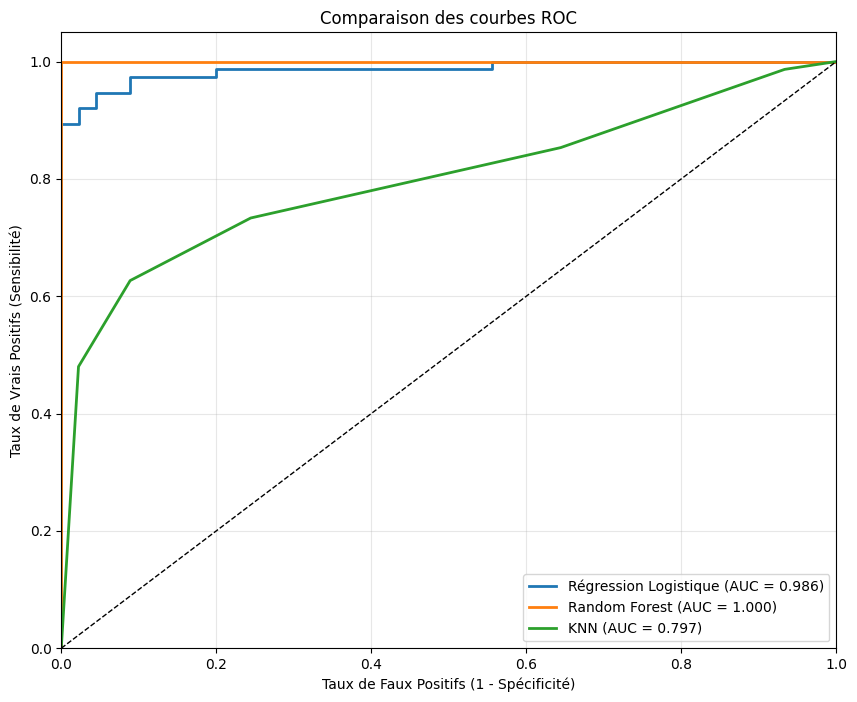

In [ ]:
# Graphique comparatif des courbes ROC
plt.figure(figsize=(10, 8))

# Courbe ROC pour la Régression Logistique
plt.plot(fpr_lr, tpr_lr, label=f'Régression Logistique (AUC = {roc_auc_lr:.3f})', linewidth=2)

# Courbe ROC pour Random Forest
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})', linewidth=2)

# Courbe ROC pour KNN
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.3f})', linewidth=2)

# Ligne de référence (classifieur aléatoire)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

# Paramètres du graphique
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Comparaison des courbes ROC')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Enregistrer et afficher
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Machines à vecteurs de support (SVM)
from sklearn.svm import SVC # Import the SVC class from sklearn.svm
svm_model = SVC(random_state=42, probability=True)  # probability=True pour les courbes ROC
svm_model.fit(X_train, y_train) # Use X_train directly
y_pred_svm = svm_model.predict(X_test) # Use X_test directly
y_prob_svm = svm_model.predict_proba(X_test)[:, 1] # Use X_test directly

# Arbres de décision
from sklearn.tree import DecisionTreeClassifier # Import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train) # Use X_train directly
y_pred_dt = dt_model.predict(X_test) # Use X_test directly
y_prob_dt = dt_model.predict_proba(X_test)[:, 1] # Use X_test directly

# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier # Import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train) # Use X_train directly
y_pred_gb = gb_model.predict(X_test) # Use X_test directly
y_prob_gb = gb_model.predict_proba(X_test)[:, 1] # Use X_test directly

# Évaluation des performances (ex: accuracy, classification_report, roc_auc_score)
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Calculer les métriques ROC pour les visualisations
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Évaluation des modèles
print("Régression Logistique - Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print("KNN - Accuracy:", accuracy_score(y_test, y_pred_knn))

# Afficher les rapports de classification
print("\nRapport de classification - Régression Logistique:\n", classification_report(y_test, y_pred_lr))
print("\nRapport de classification - Random Forest:\n", classification_report(y_test, y_pred_rf))
print("\nRapport de classification - KNN:\n", classification_report(y_test, y_pred_knn))

print("SVM - Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Decision Tree - Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Gradient Boosting - Accuracy:", accuracy_score(y_test, y_pred_gb))

SVM - Accuracy: 0.625
Decision Tree - Accuracy: 0.9916666666666667
Gradient Boosting - Accuracy: 0.9916666666666667


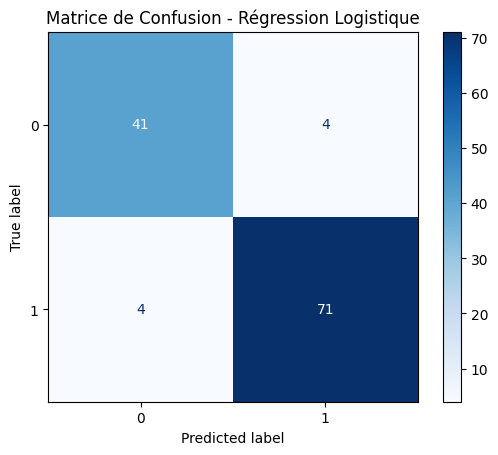

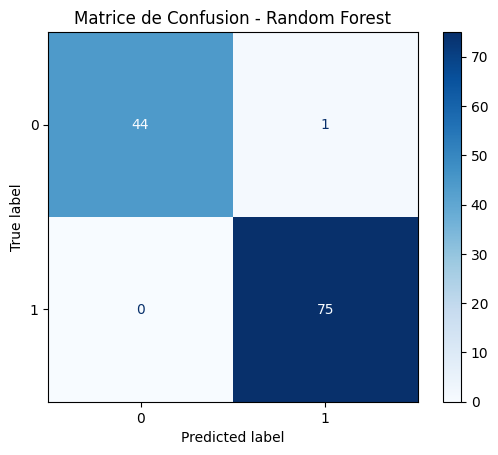

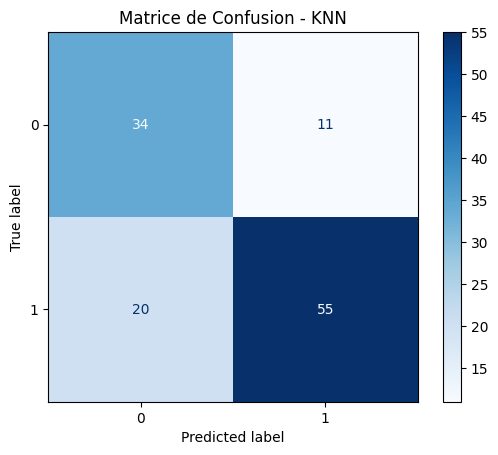

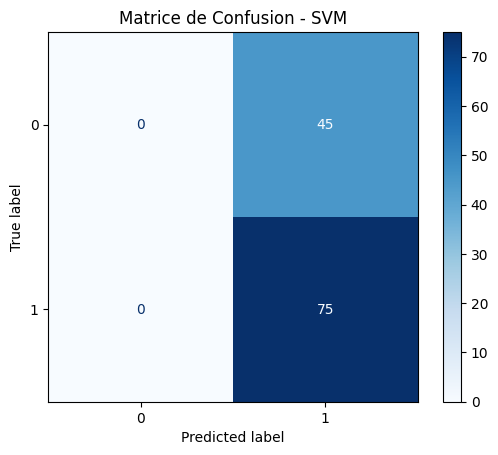

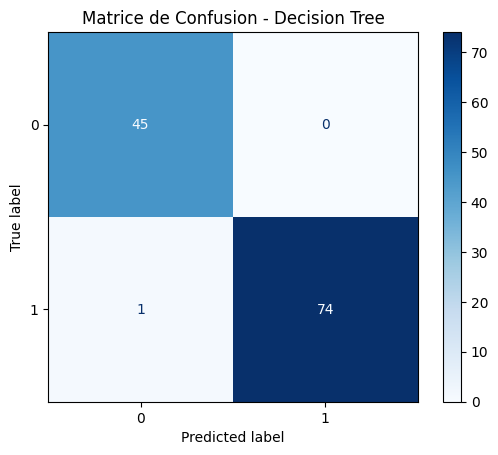

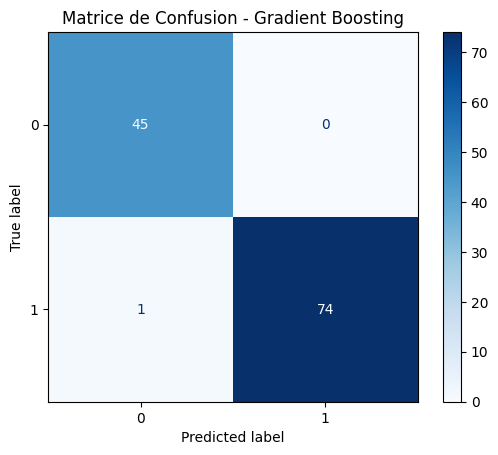

In [ ]:
# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.show()

# Afficher les matrices de confusion pour chaque modèle
plot_confusion_matrix(model_lr, X_test, y_test, 'Régression Logistique')
plot_confusion_matrix(rf_model, X_test_scaled, y_test, 'Random Forest')
plot_confusion_matrix(model_knn, X_test, y_test, 'KNN')
plot_confusion_matrix(svm_model, X_test, y_test, 'SVM')
plot_confusion_matrix(dt_model, X_test, y_test, 'Decision Tree')
plot_confusion_matrix(gb_model, X_test, y_test, 'Gradient Boosting')